## Begin


In [9]:
import json
import re
from datetime import datetime
from numbers import Number
from os import walk

import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import shapely
import shapely.geometry as geometry
from sqlalchemy import select

from fires_app.config.fires_db_config import session_factory
from fires_app.models.dacha import Dacha
from fires_app.models.fire import Fire
from fires_app.models.fire_status import FireStatus
from fires_app.models.foresst_zone import ForestZone
from fires_app.models.forest_quarter import ForestQuarter
from fires_app.models.forest_seed_zoning_zone import ForestSeedZoningZone
from fires_app.models.forestry import Forestry
from fires_app.models.meteo_record import MeteoRecord
from fires_app.models.meteo_station import MeteoStation
from fires_app.models.territory_type import TerritoryType
from fires_app.models.uch_forestry import UchForestry
from fires_app.models.weather_event import WeatherEvent
from fires_app.models.weather_event_type import WeatherEventType
from transliterate import translit, get_available_language_codes

base_path = "../FINAL data/"
my_data_path = "../data/"

In [12]:
def str_to_multipoly(lst):
    # В некоторых строках вместо ',' стоят ';', тогда json не читается
    lst = lst.replace(";", ",")
    j = json.loads(lst)
    polygons = []
    for p in j:
        p = geometry.shape(p)
        polygons.append(p)

    polygons = geometry.MultiPolygon(polygons)
    return geometry.MultiPolygon(polygons)


def pd_to_gpd_w_geom(df, geom_field_name="geom"):
    print(type(df[geom_field_name][0]))
    geoms = []
    if isinstance(df[geom_field_name][0], str):
        # geoms = df[geom_field_name]
        for shape in df[geom_field_name]:
            # print(shape)
            geoms.append(shapely.from_wkt(shape))
    else: 
        for shape in df[geom_field_name]:
            # print(shape)
            geoms.append(shapely.from_wkb(shape))

    gdf = gpd.GeoDataFrame(df, geometry=geoms, crs="EPSG:4326")
    return gdf

def repalce_geometry_with_wkb(df):
    wkb = df.geometry.to_wkb(hex=True)
    df.drop(columns=["geometry"], inplace=True)
    df.rename(columns={"poly": "geom"}, inplace=True)
    df["geom"] = wkb
    return df

In [7]:
session = session_factory()

## Meteo


### Метеостанции

In [5]:
mypath = base_path + "/metadata/weather_data"
filenames = next(walk(mypath), (None, None, []))[2]  # [] if no file

In [5]:
codes = []

for i in range(len(filenames)):
    filenames[i] = filenames[i].split(".")[0]
    code = [int(s) for s in re.findall(r"\b\d+\b", filenames[i])]
    if len(code) == 0:
        print(i, filenames[i])
    else:
        code = code[0]

    codes.append(code)

print(len(codes))

9 Братск Аэропорт UIBB
67


In [6]:
for i in range(len(filenames)):
    filenames[i] = filenames[i].replace(" " + str(codes[i]), "")

filenames[9] = "Братск Аэропорт"

In [6]:
mypath = base_path + "/metadata/weather_coords.csv"

df_weather = pd.read_csv(mypath)

df_weather.head()

,weather_station_id,date,WW,T,Ff,P,U,VV,Td,RRR,WW_code,lon,lat,WW_type
0,24817,2017-01-01,"Осадки в поле зрения, достигающие поверхности ...",-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,66,108.02,61.27,NaN
1,24817,2017-01-01,Облака в целом рассеиваются или становятся мен...,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,63,108.02,61.27,облачно
2,24817,2017-01-01,Ливневый снег слабый в срок наблюдения или за ...,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,41,108.02,61.27,снег
3,24817,2017-01-01,,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,0,108.02,61.27,NaN
4,24817,2017-01-01,Ливневый снег или ливневый дождь и снег.,-13.8,2.125,755.15,90.625,30.0,-14.9875,0.45,39,108.02,61.27,снег


In [8]:
len(df_weather["weather_station_id"].unique())

61

In [9]:
stations_unique = df_weather.weather_station_id.unique().tolist()

stations_coords = []

codes_final = []
names_final = []
for i in range(len(codes)):
    if codes[i] in stations_unique and codes[i] not in codes_final:
        lon = df_weather[df_weather["weather_station_id"] == codes[i]]["lon"].values[0]
        lat = df_weather[df_weather["weather_station_id"] == codes[i]]["lat"].values[0]
        stations_coords.append(shapely.Point(lon, lat))
        print(f'{codes[i]} {filenames[i]}')
        codes_final.append(codes[i])
        names_final.append(filenames[i])

len(codes_final)

29894 Алыгджер
30715 Ангарск
30818 Байкальск
30612 Балаганск
30627 Баяндай
30727 Большое Голоустное
30632 Большой Ушканий о
30618 Бохан
30309 Братск
30229 Верхне-Марково
29789 Верхняя Гутара
30726 Еланцы 
24817 Ербогачен
30209 Ершово
30521 Жигалово
30606 Залари
30317 Заярск
30603 Зима
30028 Ика
30507 Икей
30703 Инга
30791 Иркутск Аэропорт
30337 Казачинское
30406 Калтук
30437 Карам
30622 Качуг
30230 Киренск
30812 Култук
30219 Максимово
30157 Мама
30252 Мамакан
30802 Монды
29794 Нерой
30433 Нижнеангарск
29698 Нижнеудинск
30218 Новая Игирма
29590 Новочунка
29998 Орлик
30328 Орлинга
30069 Перевоз
24918 Преображенка
30537 Солнечная
29594 Тайшет
30405 Тангуй
30127 Токма
30439 Томпа
30504 Тулун
30526 Тырка
30637 Узуры
30210 Усть Илимск
30323 Усть-Кут
30713 Усть-Ордынский
30514 Усть-Уда
29892 Хадама
30714 Хайта
30815 Хамар-Дабан
30716 Хомутово
30629 Хужир
29393 Червянка
30617 Черемхово
29498 Шиткино


61

In [10]:
stations = []

with session:
    for i in range(len(codes_final)):
        station = MeteoStation(
            name=names_final[i], code=codes_final[i], coords=str(stations_coords[i])
        )
        stations.append(station)

    session.add_all(stations)
    session.commit()
    print(stations[0])

2024-04-24 23:22:15,655 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-24 23:22:15,657 INFO sqlalchemy.engine.Engine INSERT INTO meteo_stations (name, code, coords) SELECT p0::VARCHAR, p1::VARCHAR, p2::geometry(POINT,-1) FROM (VALUES (%(name__0)s::VARCHAR, %(code__0)s::VARCHAR, ST_GeomFromEWKT(%(coords__0)s), 0), (%(name__1)s::VARCHAR, %(code__1)s::VARCHAR, ST_Geom ... 5024 characters truncated ... 0, p1, p2, sen_counter) ORDER BY sen_counter RETURNING meteo_stations.id, meteo_stations.id AS id__1
2024-04-24 23:22:15,658 INFO sqlalchemy.engine.Engine [generated in 0.00014s (insertmanyvalues) 1/1 (ordered)] {'name__0': 'Алыгджер', 'code__0': 29894, 'coords__0': 'POINT (98.22 53.63)', 'name__1': 'Ангарск', 'code__1': 30715, 'coords__1': 'POINT (103.85 52.48)', 'name__2': 'Байкальск', 'code__2': 30818, 'coords__2': 'POINT (104.09 51.39)', 'name__3': 'Балаганск', 'code__3': 30612, 'coords__3': 'POINT (103.33 53.72)', 'name__4': 'Баяндай', 'code__4': 30627, 'coords__4': 'POINT (105.

### Записи о погоде

In [8]:
weather_events_codes = []
weather_events_names = []
weather_event_types = []

for w in df_weather["WW_code"].unique():
    uw = df_weather[df_weather["WW_code"] == w]["WW"].unique()[0]
    weather_events_codes.append(w)
    weather_events_names.append(uw)

for w in df_weather["WW_type"].unique():
    if pd.isna(w):
        w = "NA"
    weather_event_types.append(w)

print(weather_events_codes)
print(weather_events_names)
print(weather_event_types)

[66, 63, 41, 0, 39, 88, 83, 91, 61, 104, 98, 103, 65, 28, 67, 76, 86, 77, 40, 45, 48, 51, 69, 9, 15, 5, 3, 53, 58, 106, 38, 49, 43, 105, 89, 108, 35, 99, 100, 44, 82, 33, 31, 2, 112, 54, 59, 23, 102, 4, 50, 18, 25, 87, 74, 70, 60, 75, 34, 93, 24, 30, 81, 72, 46, 42, 36, 113, 96, 1, 92, 7, 115, 68, 110, 26, 80, 78, 47, 97, 6, 79, 21, 114, 73, 12, 29, 64, 71, 20, 90, 32, 56, 94, 57, 8, 13, 22, 84, 55, 37, 27, 116, 111, 14, 107, 52, 95, 62, 16, 109, 17, 101, 10, 11, 85, 19]
['Осадки в поле зрения, достигающие поверхности земли или моря поблизости, но не на самой станции. ', 'Облака в целом рассеиваются или становятся менее развитыми. ', 'Ливневый снег слабый в срок наблюдения или за последний час. ', ' ', 'Ливневый снег или ливневый дождь и снег. ', 'Снег непрерывный слабый в срок наблюдения. ', 'Слабый или умеренный поземок в целом низкий (ниже уровня глаз наблюдателя). ', 'Снег с перерывами слабый в срок наблюдения. ', 'Облака в целом образовывались или развивались. ', 'Туман или ледяно

In [30]:
we_types = []

with session:
    for type in weather_event_types:
        weather_event_type = WeatherEventType(name_ru=type)
        we_types.append(weather_event_type)

    session.add_all(we_types)
    session.commit()

2024-04-24 23:44:53,852 INFO sqlalchemy.engine.Engine INSERT INTO weather_event_types (name_ru) SELECT p0::VARCHAR FROM (VALUES (%(name_ru__0)s::VARCHAR, 0), (%(name_ru__1)s::VARCHAR, 1), (%(name_ru__2)s::VARCHAR, 2), (%(name_ru__3)s::VARCHAR, 3), (%(name_ru__4)s::VARCHAR, 4), (%(name_ru__5)s::VARCHAR,  ... 170 characters truncated ...  sen_counter) ORDER BY sen_counter RETURNING weather_event_types.id, weather_event_types.id AS id__1
2024-04-24 23:44:53,853 INFO sqlalchemy.engine.Engine [generated in 0.00007s (insertmanyvalues) 1/1 (ordered)] {'name_ru__0': 'NA', 'name_ru__1': 'облачно', 'name_ru__2': 'снег', 'name_ru__3': 'туман', 'name_ru__4': 'дымка', 'name_ru__5': 'дождь', 'name_ru__6': 'пыль', 'name_ru__7': 'гроза', 'name_ru__8': 'морось', 'name_ru__9': 'град', 'name_ru__10': 'ветер'}
2024-04-24 23:44:53,854 INFO sqlalchemy.engine.Engine COMMIT


In [25]:
weather_events_types_map = {}
for t in df_weather["WW_type"].unique():
    if pd.isna(t):
        t = "NA"

    weather_events_types_map[t] = []



for w in df_weather["WW_code"].unique():
    ut = df_weather[df_weather["WW_code"] == w]["WW_type"].unique()[0]
    if pd.isna(ut):
        ut = "NA"
    weather_events_types_map[w].append(ut)

print(weather_events_types_map)

# weather_events_types_map.

{'NA': [66, 0, 65, 67, 97, 64], 'облачно': [63, 61, 72, 62], 'снег': [41, 39, 88, 83, 91, 76, 86, 77, 40, 43, 89, 87, 81, 42, 92, 68, 90, 94, 27, 85], 'туман': [104, 98, 103, 106, 105, 108, 99, 100, 31, 2, 112, 102, 110, 111, 107, 109, 101], 'дымка': [28, 3, 53, 52], 'дождь': [45, 48, 51, 49, 44, 23, 50, 18, 25, 24, 46, 113, 26, 47, 20, 22, 84, 19], 'пыль': [69, 74, 70, 75, 1, 115, 80, 78, 79, 73, 71], 'гроза': [9, 15, 5, 82, 4, 7, 6, 114, 12, 8, 13, 14, 16, 17, 10, 11], 'морось': [58, 54, 59, 60, 30, 21, 29, 56, 57, 55], 'град': [38, 35, 33, 34, 93, 36, 96, 32, 37, 95], 'ветер': [116]}


In [90]:
types = select(WeatherEventType)
types = session.scalars(types).all()

types_ids_names = {}
for t in types:
    types_ids_names[t.name_ru] = t.id

weather_events = []
for i in range(len(weather_events_names)):
    for j in weather_events_types_map:
        if weather_events_codes[i] in weather_events_types_map[j]:
            type = types_ids_names[j]
    
    
    # print(weather_events_names[i])
    weather_event = WeatherEvent(
        description_ru=str(weather_events_names[i]),
        code=int(weather_events_codes[i]),
        weather_event_type_id=int(type),
    )
    # if weather_event.weather_event_type_id
    # print(weather_event.weather_event_type_id)
    weather_events.append(weather_event)

session.add_all(weather_events)
session.commit()

# print(types_ids_names)

2024-04-25 00:55:12,215 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-25 00:55:12,215 INFO sqlalchemy.engine.Engine SELECT weather_event_types.id, weather_event_types.name_ru 
FROM weather_event_types
2024-04-25 00:55:12,216 INFO sqlalchemy.engine.Engine [cached since 2857s ago] {}
2024-04-25 00:55:12,221 INFO sqlalchemy.engine.Engine INSERT INTO weather_events (code, description_ru, weather_event_type_id) SELECT p0::INTEGER, p1::VARCHAR, p2::INTEGER FROM (VALUES (%(code__0)s::INTEGER, %(description_ru__0)s::VARCHAR, %(weather_event_type_id__0)s::INTEGER, 0), (%(code__1)s::INTEGER ... 11855 characters truncated ... 0, p1, p2, sen_counter) ORDER BY sen_counter RETURNING weather_events.id, weather_events.id AS id__1
2024-04-25 00:55:12,222 INFO sqlalchemy.engine.Engine [cached since 1503s ago (insertmanyvalues) 1/1 (ordered)] {'description_ru__0': 'Осадки в поле зрения, достигающие поверхности земли или моря поблизости, но не на самой станции. ', 'weather_event_type_id__0': 1, '

### Записи о погодных явлениях


In [4]:
met_db = select(MeteoStation)

stations_DB = session.scalars(met_db).all()

stations_ids_codes = {}
stations_ids = {}
for st in stations_DB:
    stations_ids[st.id] = st
    stations_ids_codes[st.code] = st.id
    
ww_db = select(WeatherEvent)

ww_items_DB = session.scalars(ww_db).all()

ww_ids_codes = {}

wws_ids = {}
for ww in ww_items_DB:
    wws_ids[ww.id] = ww
    ww_ids_codes[ww.code] = ww.id

In [7]:
weather_grouped = df_weather.groupby(
    [df_weather["weather_station_id"], df_weather["date"]]
)

meteo_records = []
for gr in weather_grouped:
    sample = df_weather[
        (df_weather["weather_station_id"] == gr[0][0])
        & (df_weather["date"] == gr[0][1])
    ]

    d = datetime.strptime(sample.date.values[0], "%Y-%m-%d").date()
    station_id = stations_ids_codes[str(sample.weather_station_id.values[0])]
    temp = sample["T"].values[0]
    precipitation = sample["RRR"].values[0]
    pres = sample["P"].values[0]
    wet = sample["U"].values[0]
    vis = sample["VV"].values[0]
    wind = sample["Ff"].values[0]
    ww_codes = sample["WW_code"].unique().tolist()
    # ww_ids = []
    wws = []
    for i in range(len(ww_codes)):
        wws.append(wws_ids[ww_ids_codes[ww_codes[i]]])
        # ww_ids.append(ww_ids_codes[ww_codes[i]])

    # print(temp)
    met_record = MeteoRecord(
        date=d,
        precipitation_mm=float(precipitation),
        temp_celsius=float(temp),
        wind_speed_ms=float(wind),
        atm_pres_mmhg=float(pres),
        rel_wetness_perc=float(wet),
        hor_visibility_km=float(vis),
        meteo_station=stations_ids[station_id],
        #  weather_events=wws
    )
    # sf.add(met_record)
    met_record.weather_events = wws
    meteo_records.append(met_record)
    #  wws_ids[station_id]
    # meteo_record.weather_events.append

In [8]:
len(meteo_records)

81482

In [9]:
session.rollback()

In [10]:
session.add_all(meteo_records)

session.commit()

## CSV


### final_rosleshoz.csv


In [81]:
file_name = "final_rosleshoz.csv"
path = base_path + "/" + file_name
final_rosleshoz_df = pd.read_csv(path)

In [82]:
final_rosleshoz_df.head()

,new_fire_id,code,coords,locality_distance,lesn,date_start,area_registr,date_end,status,area_all,...,duration,month,status_category,area_union,count_ignitions,points,_typename,geometry,type,ids
0,7463,к-440 (112108),"53° 04' 26"" с.ш.\n102° 32' 53"" в.д.","н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,ликвидирован 14.04.2020,454,...,1,4,ликвидирован,4.54,1,NaN,Аларь,MULTIPOLYGON (((11416662.69007241 6997742.4409...,НП,[7463]
1,8614,к-1605 (213710),"53° 11' 49"" с.ш.\n102° 14' 53"" в.д.","н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,ликвидирован 4.07.2020,82,...,0,6,ликвидирован,0.82,1,NaN,Аляты,MULTIPOLYGON (((11382654.2483037 7019963.49327...,НП,[8614]
2,4406,к-600 (169231),"53° 27' 54"" с.ш.\n103° 21' 29"" в.д.","н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,ликвидирован 4.05.2019,17,...,0,4,ликвидирован,0.17,1,NaN,Ангарский,MULTIPOLYGON (((11505972.26910861 7069683.9770...,НП,[4406]
3,7567,к-539 (116005),"53° 25' 16"" с.ш.\n102° 57' 43"" в.д.","н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,ликвидирован 14.04.2020,28,...,0,4,ликвидирован,0.28,1,NaN,Дута,MULTIPOLYGON (((11461935.80177199 7061539.7212...,НП,[7567]
4,8808,к-1797 (218004),"53° 18' 22"" с.ш.\n103° 00' 29"" в.д.","н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,ликвидирован 11.07.2020,7,...,0,7,ликвидирован,0.07,1,NaN,Егоровская,MULTIPOLYGON (((11466936.57961523 7039954.4280...,НП,[8808]


Разница между area и are_union есть


In [40]:
final_rosleshoz_df[
    final_rosleshoz_df["area_all_km"] != final_rosleshoz_df["area_union"]
][["area_union", "area_all_km", "area_all"]]

,area_union,area_all_km,area_all
67,0.06,0.03,3
82,0.06,0.03,3
140,487.17,481.15,48115
160,47.20,46.30,4630
201,38.77,38.35,3835
...,...,...,...
9104,0.06,0.03,3
9105,0.06,0.03,3
9106,0.06,0.03,3
9177,0.17,0.14,14


Удалим колонки, дублирующие другие колонки по площади.


In [83]:
final_rosleshoz_df.drop(
    columns=["coords", "area_all_km", "area_forest_km", "count_ignitions"], inplace=True
)

Ниже видно, что есть id пожара не обязательно равен id нового пожара.


In [42]:
len(final_rosleshoz_df[final_rosleshoz_df["id"] != final_rosleshoz_df["new_fire_id"]])

120

Поажры, у которых начало и конец в разных годах. Year — год начала. То же касается месяца.


In [43]:
final_rosleshoz_df[
    (pd.to_datetime(final_rosleshoz_df["date_start"], format="%Y-%m-%d").dt.month == 12)
    & (pd.to_datetime(final_rosleshoz_df["date_end"], format="%Y-%m-%d").dt.month == 1)
][["date_start", "date_end", "year"]]

,date_start,date_end,year
1296,2018-12-12,2019-01-05,2018
1391,2018-12-24,2019-01-16,2018
1450,2018-12-21,2019-01-09,2018
4539,2018-12-30,2019-01-06,2018
9274,2020-12-04,2021-01-11,2020
9275,2020-12-05,2021-01-11,2020


Удалим дублирование по времени


In [84]:
final_rosleshoz_df.drop(
    columns=["day_start", "day_end", "year", "month", "duration"], inplace=True
)

Удалим лишние поля


In [85]:
final_rosleshoz_df.drop(
    columns=[
        "points",
        "ids",
        "ps",
        "ps2",
        "buffer",
        "new_fire_id",
        "delta_area_all",
        "delta_area_forest",
    ],
    inplace=True,
)

# final_rosleshoz_df.drop(columns = ["lat", "lon", "status"], inplace=True)

In [86]:
final_rosleshoz_df.head()

,code,locality_distance,lesn,date_start,area_registr,date_end,status,area_all,area_forest,area_lesofond_all,...,lat,lon,forest,id,geometry_point,status_category,area_union,_typename,geometry,type
0,к-440 (112108),"н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,ликвидирован 14.04.2020,454,0,87,...,53.073889,102.548056,0.0,7463,POINT (11415597.32628477 6996677.077121332),ликвидирован,4.54,Аларь,MULTIPOLYGON (((11416662.69007241 6997742.4409...,НП
1,к-1605 (213710),"н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,ликвидирован 4.07.2020,82,0,3,...,53.196944,102.248056,0.0,8614,POINT (11382201.47904679 7019510.724017813),ликвидирован,0.82,Аляты,MULTIPOLYGON (((11382654.2483037 7019963.49327...,НП
2,к-600 (169231),"н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,ликвидирован 4.05.2019,17,1,9,...,53.465000,103.358056,1.0,4406,POINT (11505766.11382733 7069477.82176244),ликвидирован,0.17,Ангарский,MULTIPOLYGON (((11505972.26910861 7069683.9770...,НП
3,к-539 (116005),"н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,ликвидирован 14.04.2020,28,21,11,...,53.421111,102.961944,1.0,7567,POINT (11461671.22664088 7061275.146122432),ликвидирован,0.28,Дута,MULTIPOLYGON (((11461935.80177199 7061539.7212...,НП
4,к-1797 (218004),"н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,ликвидирован 11.07.2020,7,2,7,...,53.306111,103.008056,1.0,8808,POINT (11466804.29204968 7039822.14047591),ликвидирован,0.07,Егоровская,MULTIPOLYGON (((11466936.57961523 7039954.4280...,НП


In [94]:
coords = shapely.points(final_rosleshoz_df["lon"], final_rosleshoz_df["lat"])

les_gpd = gpd.GeoDataFrame(final_rosleshoz_df, geometry=coords)

les_gpd.head()

,code,locality_distance,lesn,date_start,area_registr,date_end,status,area_all,area_forest,area_lesofond_all,...,lat,lon,forest,id,geometry_point,status_category,area_union,_typename,geometry,type
0,к-440 (112108),"н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,ликвидирован 14.04.2020,454,0,87,...,53.073889,102.548056,0.0,7463,POINT (11415597.32628477 6996677.077121332),ликвидирован,4.54,Аларь,POINT (102.54806 53.07389),НП
1,к-1605 (213710),"н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,ликвидирован 4.07.2020,82,0,3,...,53.196944,102.248056,0.0,8614,POINT (11382201.47904679 7019510.724017813),ликвидирован,0.82,Аляты,POINT (102.24806 53.19694),НП
2,к-600 (169231),"н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,ликвидирован 4.05.2019,17,1,9,...,53.465000,103.358056,1.0,4406,POINT (11505766.11382733 7069477.82176244),ликвидирован,0.17,Ангарский,POINT (103.35806 53.46500),НП
3,к-539 (116005),"н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,ликвидирован 14.04.2020,28,21,11,...,53.421111,102.961944,1.0,7567,POINT (11461671.22664088 7061275.146122432),ликвидирован,0.28,Дута,POINT (102.96194 53.42111),НП
4,к-1797 (218004),"н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,ликвидирован 11.07.2020,7,2,7,...,53.306111,103.008056,1.0,8808,POINT (11466804.29204968 7039822.14047591),ликвидирован,0.07,Егоровская,POINT (103.00806 53.30611),НП


Записываем в csv


In [48]:
path = my_data_path + "/" + file_name
final_rosleshoz_df.to_csv(path, index=False)

OSError: Cannot save file into a non-existent directory: '..\..\MY data'

#### Перенос в БД


##### Статусы пожаров (THIS)

In [49]:
for status in les_gpd["status_category"].unique():
    stat = FireStatus(name=status)
    session.add(stat)

session.commit()

##### Типы территорий (THIS)

In [51]:
t = les_gpd["type"].unique()[0]
t1 = TerritoryType(name=t)
session.add(t1)
t2 = TerritoryType(name=les_gpd["type"].unique()[1])
session.add(t2)
session.commit()

In [ ]:
les_gpd.head()

,code,locality_distance,lesn,date_start,area_registr,date_end,status,area_all,area_forest,area_lesofond_all,...,lat,lon,forest,id,geometry_point,status_category,area_union,_typename,geometry,type
0,к-440 (112108),"н.п. Аларь, азимут 38°, удаление 0.5 км",Аларское,2020-04-08,90.0,2020-04-09,ликвидирован 14.04.2020,454,0,87,...,53.073889,102.548056,0.0,7463,POINT (11415597.32628477 6996677.077121332),ликвидирован,4.54,Аларь,POINT (102.54806 53.07389),НП
1,к-1605 (213710),"н.п. Аляты, азимут 140°, удаление 2.4 км",Аларское,2020-06-29,80.0,2020-06-29,ликвидирован 4.07.2020,82,0,3,...,53.196944,102.248056,0.0,8614,POINT (11382201.47904679 7019510.724017813),ликвидирован,0.82,Аляты,POINT (102.24806 53.19694),НП
2,к-600 (169231),"н.п. Ангарский, азимут 32°, удаление 0.6 км",Аларское,2019-04-29,17.0,2019-04-29,ликвидирован 4.05.2019,17,1,9,...,53.465000,103.358056,1.0,4406,POINT (11505766.11382733 7069477.82176244),ликвидирован,0.17,Ангарский,POINT (103.35806 53.46500),НП
3,к-539 (116005),"н.п. Табарсук, азимут 117°, удаление 4.4 км",Аларское,2020-04-09,3.0,2020-04-09,ликвидирован 14.04.2020,28,21,11,...,53.421111,102.961944,1.0,7567,POINT (11461671.22664088 7061275.146122432),ликвидирован,0.28,Дута,POINT (102.96194 53.42111),НП
4,к-1797 (218004),"н.п. Егоровская, азимут 252°, удаление 0.8 км",Аларское,2020-07-06,6.0,2020-07-06,ликвидирован 11.07.2020,7,2,7,...,53.306111,103.008056,1.0,8808,POINT (11466804.29204968 7039822.14047591),ликвидирован,0.07,Егоровская,POINT (103.00806 53.30611),НП


##### Пожары

In [89]:
forestries = select(Forestry)
forestries = session.scalars(forestries).all()

forestries_names = {}
for f in forestries:
    forestries_names[f.name_ru] = f

statuses = select(FireStatus)
statuses = session.scalars(statuses).all()

statuses_names = {}
for s in statuses:
    statuses_names[s.name] = s

tts = select(TerritoryType)
tts = session.scalars(tts).all()

tts_names = {}
for t in tts:
    tts_names[t.name] = t

In [90]:
forest_bd = list(forestries_names.keys())
forest_bd

['Аларское',
 'Ангарское',
 'Балаганское',
 'Баяндаевское',
 'Бирунское',
 'Бодайбинское',
 'Братское',
 'Буринское',
 'Черемховское',
 'Чунское',
 'Голоустненское',
 'Харетское',
 'Илимское',
 'Иркутское',
 'Жигаловское',
 'Качугское',
 'Катангское',
 'Казачинско-Ленское',
 'Киренское',
 'Кировское',
 'Куйтунское',
 'Мамское',
 'Нижнеилимское',
 'Нижнеудинское',
 'Нукутское',
 'Ольхонское',
 'Осинское',
 'Падунское',
 'Северное',
 'Шелеховское',
 'Слудянское',
 'Тайшетское',
 'Тулунское',
 'Усольское',
 'Усть-Кутское',
 'Усть-Ордынское',
 'Усть-Удинское',
 'Заларинское',
 'Зиминское']

In [91]:
uchf = select(UchForestry)
uchf = session.scalars(uchf).all()
uchf_n = {}

for u in uchf:
    uchf_n[u.name_ru] = u

uchf_n.keys()

dict_keys(['Аларское', 'Приморское', 'Заречное', 'Тальцинское', 'Ушаковское', 'Технический участок №1 ЗАО Савватеевское', 'Балаганское', 'Хоготское', 'Баяндаевское', 'Кондратьевское', 'Шелаевское', 'Бодайбинское', 'Вихоревское', 'Илирское', 'Братское', 'Тангуйское', 'Тарминское', 'Маральское', 'Буринская', 'Голуметское', 'Мало-Бельское', 'Выдринское', 'Червянское', 'Мироновское', 'Неванское', 'Невонское', 'Малоголоустненское', 'Большеголоустненское', 'Харетское', 'Усть-Илимское', 'Воробьевское', 'Седановское', 'Гороховское', 'Хомутовское', 'Жигаловское', 'Тутурское', 'Ангинское', 'Верхоленское', 'Катангское', 'Казачинское', 'Ульканское', 'Карамское', 'Магистральное', 'Ичерское', 'Чайское', 'Киренское', 'Карелинское', 'Тихоновское', 'Боханское', 'Кировское', 'Куйтунское', 'Барлукское', 'Мамское', 'Ярское', 'Игирминское', 'Рудногорское', 'Железногорское', 'Верхнеилимское', 'Каменское', 'Боровинское', 'Тофаларское', 'Нижнеудинское', 'Замзорское', 'Алзамайское', 'Новонукутское', 'Ольхонско

In [92]:
l = list(uchf_n.keys())
for i in range(len(l)):
    l[i] = l[i].replace(" ", "")
l.sort()
l

['Аларское',
 'Алзамайское',
 'Ангарское',
 'Ангинское',
 'Байкальское',
 'Байтогское',
 'Балаганское',
 'Барлукское',
 'Баяндаевское',
 'Бобровское',
 'Бодайбинское',
 'Большеголоустненское',
 'Борисовское',
 'Боровинское',
 'Боровское',
 'Боханское',
 'Братское',
 'Бугульдейское',
 'Будаговское',
 'Буринская',
 'Буринское',
 'Бурят-Янгутское',
 'Верхнебирюсинское',
 'Верхнеилимское',
 'Верхненепское',
 'Верхоленское',
 'Вихоревское',
 'Воробьевское',
 'Выдринское',
 'Голуметское',
 'Гороховское',
 'Железногорское',
 'Жигаловское',
 'Замзорское',
 'Заречное',
 'Зелендинско-Катинское',
 'Зулумайское',
 'Игирминское',
 'Икейское',
 'Илирское',
 'Ичерское',
 'Казачинское',
 'Каймоновское',
 'Каменское',
 'Карамское',
 'Карахунское',
 'Карелинское',
 'Катангское',
 'Киренское',
 'Кировское',
 'Кондратьевское',
 'Куйтунское',
 'Магистральное',
 'Мало-Бельское',
 'Малоголоустненское',
 'Мамское',
 'Маральское',
 'Марковское',
 'Мироновское',
 'Неванское',
 'Невонское',
 'Нижнеудинское',
 'Н

In [112]:
fires = []
for i in range(len(les_gpd)):
    f = les_gpd.loc[i]
    fire = Fire(
        code=f["code"],
        coords=str(f["geometry"]),
        date_start=datetime.strptime(f["date_start"], "%Y-%m-%d").date(),
        date_end=datetime.strptime(f["date_end"], "%Y-%m-%d").date(),
        is_forest=int(f["forest"]),  # f["forest"],
        area_all=float(f["area_all"]),
        area_forest=float(f["area_forest"]),
        area_registr=float(f["area_registr"]),
        area_lesofond_all=float(f["area_lesofond_all"]),
        area_lesofond_forest=float(f["area_lesofond_forest"]),
        area_union=float(f["area_union"]),
        fire_status=statuses_names[f["status_category"]],
    )

    if f["lesn"] in forestries_names:
        fire.forestry = forestries_names[f["lesn"]]

    if not pd.isna(f["type"]):
        fire.territory_type = tts_names[f["type"]]

    fires.append(fire)

In [115]:
session.rollback()

In [114]:
session.add_all(fires)
session.commit()

ProgrammingError: (psycopg.ProgrammingError) cannot adapt type 'int64' using placeholder '%s' (format: AUTO)
[SQL: INSERT INTO fires (code, coords, date_start, date_end, is_forest, area_all, area_forest, area_lesofond_all, area_lesofond_forest, area_union, area_registr, forestry_id, fire_status_id, territory_type_id) SELECT p0::VARCHAR, p1::geometry(POINT,-1), p2 ... 381544 characters truncated ...  p8, p9, p10, p11, p12, p13, sen_counter) ORDER BY sen_counter RETURNING fires.id, fires.id AS id__1]
[parameters: {'code__0': 'к-440 (112108)', 'area_all__0': 454, 'is_forest__0': False, 'fire_status_id__0': 1, 'area_union__0': 4.54, 'area_lesofond_all__0': 87.0, 'forestry_id__0': 1, 'territory_type_id__0': 1, 'date_end__0': datetime.date(2020, 4, 9), 'coords__0': 'POINT (102.54805555555556 53.073888888888895)', 'date_start__0': datetime.date(2020, 4, 8), 'area_forest__0': 0.0, 'area_registr__0': 90.0, 'area_lesofond_forest__0': 0.0, 'code__1': 'к-1605 (213710)', 'area_all__1': 82, 'is_forest__1': False, 'fire_status_id__1': 1, 'area_union__1': 0.82, 'area_lesofond_all__1': 3.0, 'forestry_id__1': 1, 'territory_type_id__1': 1, 'date_end__1': datetime.date(2020, 6, 29), 'coords__1': 'POINT (102.24805555555557 53.19694444444444)', 'date_start__1': datetime.date(2020, 6, 29), 'area_forest__1': 0.0, 'area_registr__1': 80.0, 'area_lesofond_forest__1': 0.0, 'code__2': 'к-600 (169231)', 'area_all__2': 17, 'is_forest__2': True, 'fire_status_id__2': 1, 'area_union__2': 0.17, 'area_lesofond_all__2': 9.0, 'forestry_id__2': 1, 'territory_type_id__2': 1, 'date_end__2': datetime.date(2019, 4, 29), 'coords__2': 'POINT (103.35805555555557 53.465)', 'date_start__2': datetime.date(2019, 4, 29), 'area_forest__2': 1.0, 'area_registr__2': 17.0, 'area_lesofond_forest__2': 0.0, 'code__3': 'к-539 (116005)', 'area_all__3': 28, 'is_forest__3': True, 'fire_status_id__3': 1, 'area_union__3': 0.28, 'area_lesofond_all__3': 11.0, 'forestry_id__3': 1, 'territory_type_id__3': 1 ... 13900 parameters truncated ... 'forestry_id__996': 33, 'territory_type_id__996': 1, 'date_end__996': datetime.date(2020, 4, 12), 'coords__996': 'POINT (100.56194444444444 54.57611111111112)', 'date_start__996': datetime.date(2020, 4, 12), 'area_forest__996': 6.0, 'area_registr__996': 53.0, 'area_lesofond_forest__996': 0.0, 'code__997': 'к-1517 (209382)', 'area_all__997': 53, 'is_forest__997': True, 'fire_status_id__997': 1, 'area_union__997': 0.53, 'area_lesofond_all__997': 5.0, 'forestry_id__997': 33, 'territory_type_id__997': 1, 'date_end__997': datetime.date(2020, 6, 22), 'coords__997': 'POINT (100.6061111111111 54.55805555555556)', 'date_start__997': datetime.date(2020, 6, 22), 'area_forest__997': 4.0, 'area_registr__997': 53.0, 'area_lesofond_forest__997': 2.0, 'code__998': 'к-520 (39566)', 'area_all__998': 29, 'is_forest__998': False, 'fire_status_id__998': 1, 'area_union__998': 0.29, 'area_lesofond_all__998': 0.0, 'forestry_id__998': 34, 'territory_type_id__998': 1, 'date_end__998': datetime.date(2017, 3, 29), 'coords__998': 'POINT (103.665 52.74805555555556)', 'date_start__998': datetime.date(2017, 3, 29), 'area_forest__998': 0.0, 'area_registr__998': 29.0, 'area_lesofond_forest__998': 0.0, 'code__999': 'к-756 (68731)', 'area_all__999': 42, 'is_forest__999': True, 'fire_status_id__999': 1, 'area_union__999': 0.42, 'area_lesofond_all__999': 1.0, 'forestry_id__999': 34, 'territory_type_id__999': 1, 'date_end__999': datetime.date(2017, 4, 26), 'coords__999': 'POINT (103.64805555555556 52.85388888888889)', 'date_start__999': datetime.date(2017, 4, 26), 'area_forest__999': 1.0, 'area_registr__999': 20.0, 'area_lesofond_forest__999': 0.0}]
(Background on this error at: https://sqlalche.me/e/20/f405)

### lesnye_kv_3051.nearest_weather_station-forest_types.csv


In [4]:
file_name = "lesnye_kv_3051.nearest_weather_station-forest_types.csv"
path = base_path + "/Лесные кварталы/" + file_name
nws_df = pd.read_csv(path)

C:\Users\pilno\AppData\Local\Temp\ipykernel_388\1441391567.py:3: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  nws_df = pd.read_csv(path)


In [7]:
nws_df.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv_num,lesn1,lesn2,lesn3,...,geom,weather_stations,nearest_weather_station,lesn_path,lesn_path_type,distance,forest_zone,forest_seed_zoning_zone,lesn_path_FH,forest_hazard_classes
0,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,28,Аларское,Аларское,NaN,...,0106000020E6100000010000000103000000010000000A...,"30616,30606,30703,30617,30611,30603,30605,3061...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[4.0]
1,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,21,Аларское,Аларское,NaN,...,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]
2,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,22,Аларское,Аларское,NaN,...,0106000020E61000000100000001030000000100000008...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]
3,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,23,Аларское,Аларское,NaN,...,0106000020E6100000010000000103000000010000000A...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]
4,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,24,Аларское,Аларское,NaN,...,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30617,30611,30605,30603,3060...",30606,аларскоеаларскоеаларская,аларскоеаларскоеаларская,0.0,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",alarskoeаларскоеаларская,[3.0]


In [5]:
nws_df.drop(
    columns=[
        "kv_num",
        "distance",
        "lesn1",
        "lesn2",
        "lesn3",
        "lesn_path_FH",
        "lesn_path_type",
        "lesn_path",
    ],
    inplace=True,
)

In [57]:
path = my_data_path + "/" + file_name
nws_df.to_csv(path, index=False)

OSError: Cannot save file into a non-existent directory: '..\..\MY data'

In [10]:
nws_df[nws_df["dacha_ru"] == "0"]

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv,id,geom,weather_stations,nearest_weather_station,forest_zone,forest_seed_zoning_zone,forest_hazard_classes
72557,Ust-Ordinskoe,Ehirit-Bulagatskoe,Tehnicheskiy uchastok №5 sovhoz Harazargaiskiy,Усть-Ордынское,0,Эхирит-Булагатское,50,46363,0106000020E6100000010000000103000000010000000C...,"30713,30716,30627,30618,30792,30791,30715,3061...",30713,NaN,NaN,NaN


##### Перенос дач (THIS)


In [161]:
fzdb = select(ForestZone)

forest_zones_db = session.scalars(fzdb).all()
# forest_zones_db
fz_entity = {}
for z in nws_df.forest_zone.unique():
    for zdb in forest_zones_db:
        if zdb.name == z:
            fz_entity[z] = zdb

C:\Users\pilno\AppData\Local\Temp\ipykernel_16560\1074622836.py:3: SAWarning:

Object of type <Dacha> not in session, add operation along 'UchForestry.dachas' will not proceed (This warning originated from the Session 'autoflush' process, which was invoked automatically in response to a user-initiated operation.)



In [162]:
uf_names = {}

uf_db = select(UchForestry)
uf_db = session.scalars(uf_db).all()

for uf in uf_db:
    uf_names[uf.name_ru] = uf

In [164]:
dachas = []
seed_zoning_zones = []

grouped_dachas = nws_df.groupby("dacha_ru")

# Записи сгруппированы по дачам
for name, group in grouped_dachas:
    # print(group.iloc[0])
    # row = group.iloc[0]
    # Проходим по каждой группе
    if isinstance(nws_df["dacha_ru"][i], Number):
        nws_df["dacha_ru"][i] = translit(nws_df["in_dacha"][i], "ru")

    is_has_seed = False
    for i in range(len(group)):
        row = group.iloc[i]
        # Если в этой записи есть лесная зона, то берём её
        if (
            pd.notna(row["forest_zone"])
            and not row["forest_seed_zoning_zone"].isnumeric()
        ):
            zoning_split = row["forest_seed_zoning_zone"].replace(" ", "").split(",")
            print(row["forest_zone"])
            seeds = {"сосна": 0, "ель": 0, "лиственница": 0, "кедр": 0}
            print(zoning_split)
            for j in zoning_split:
                t = j.split("-")
                if len(t) > 1:
                    seeds[t[0]] = int(t[1])
                else:
                    seeds[t[0]] = 0

            seed_zoning_zone = ForestSeedZoningZone(
                pine=seeds["сосна"],
                spruce=seeds["ель"],
                larch=seeds["лиственница"],
                cedar=seeds["кедр"],
            )
            is_has_seed = True
            break
            # dacha.forest_seed_zoning_zone = seed_zoning_zone

    dacha = Dacha(name_ru=row["dacha_ru"], uch_forestry=uf_names[row["uch_l_ru"]])
    if pd.isna(row["in_dacha"]) or isinstance(nws_df["dacha_ru"][i], Number):
        dacha.name_en = translit(row["dacha_ru"], "ru", reversed=True)
    else:
        dacha.name_en = row["in_dacha"]

    if not pd.isna(row["forest_zone"]):
        forest_zone = fz_entity[row["forest_zone"]]
        dacha.forest_zone = forest_zone
    dachas.append(dacha)
    if is_has_seed:
        dacha.forest_seed_zoning_zone = seed_zoning_zone
        seed_zoning_zones.append(seed_zoning_zone)

Южно-Сибирская горная
['сосна-18', 'ель-12', 'лиственница-11', 'кедр-8']
таежная
['сосна-16', 'ель-11', 'лиственница-8', 'кедр-5']
таежная
['сосна-16', 'ель-11', 'лиственница-8', 'кедр-5']
таежная
['сосна-16', 'ель-11', 'лиственница-8', 'кедр-5']
лесостепная
['сосна-18', 'ель-10', 'лиственница-10', 'кедр-6']
таежная
['сосна-19', 'ель-11', 'лиственница-8', 'кедр-5']
таежная
['сосна-16', 'ель-9', 'лиственница-10', 'кедр-6']
лесостепная
['сосна-18', 'ель-10', 'лиственница-10', 'кедр-9']
таежная
['сосна-19', 'ель-10', 'лиственница-8', 'кедр-6']
таежная
['сосна-18', 'ель-9', 'лиственница', 'кедр']
таежная
['сосна-19', 'ель-9', 'лиственница-8', 'кедр-6']
таежная
['сосна-20', 'ель-11', 'лиственница-8', 'кедр-9']
Южно-Сибирская горная
['сосна-18', 'ель-12', 'лиственница-11', 'кедр-6']
таежная
['сосна-16', 'ель-9', 'лиственница-10', 'кедр-6']
таежная
['сосна-16', 'ель-9', 'лиственница-10', 'кедр-6']
таежная
['сосна-16', 'ель-9', 'лиственница-10', 'кедр-6']
таежная
['сосна-16', 'ель-9', 'листвен

In [163]:
session.rollback()

In [165]:
session.add_all(dachas)
session.add_all(seed_zoning_zones)

session.commit()

##### Перенос кварталов в БД (THIS)


In [6]:
mss = select(MeteoStation)
mss = session.scalars(mss).all()

mss_codes = {}
ms_unique = []
for ms in mss:
    mss_codes[ms.code] = ms
    ms_unique.append(ms.code)


ds = select(Dacha)
ds = session.scalars(ds).all()
ds_names = {}
for d in ds:
    ds_names[d.name_ru] = d


uf_db = select(UchForestry)
uf_db = session.scalars(uf_db).all()
uf_names = {}
for uf in uf_db:
    uf_names[uf.name_ru] = uf

In [7]:
nws_df.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv,id,geom,weather_stations,nearest_weather_station,forest_zone,forest_seed_zoning_zone,forest_hazard_classes
0,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,28,22562,0106000020E6100000010000000103000000010000000A...,"30616,30606,30703,30617,30611,30603,30605,3061...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[4.0]
1,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,21,22552,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]
2,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,22,22553,0106000020E61000000100000001030000000100000008...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]
3,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,23,22554,0106000020E6100000010000000103000000010000000A...,"30606,30616,30703,30611,30617,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]
4,Alarskoe,Alarskoe,NaN,Аларское,Аларская,Аларское,24,22555,0106000020E61000000100000001030000000100000009...,"30606,30616,30703,30617,30611,30605,30603,3060...",30606,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[3.0]


In [9]:
nws_df[nws_df["weather_stations"].isna()]

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv,id,geom,weather_stations,nearest_weather_station,forest_zone,forest_seed_zoning_zone,forest_hazard_classes
137,Alarskoe,Primorskoe,NaN,Аларское,Приморская,Приморское,20,17620,0106000020E61000000100000001030000000100000022...,NaN,not found,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",[4.0]
15262,Ilimskoe,Nevonskoe,NaN,Илимское,Технический участок 1 Кеульский,Невонское,7,27598,0106000020E6100000010000000103000000010000005E...,NaN,not found,NaN,NaN,NaN
75999,Zalarinskoe,Tiretskoe,Tehnicheskiy uchastok № 5 s-z ''Holmogorskij',Заларинское,Технический участок № 5 с-з Холмогойский,Тыретское,4,30924,0106000020E61000000100000001030000000100000020...,NaN,not found,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6",NaN


In [77]:
quarters = []


for i in range(len(nws_df)):
    row = nws_df.loc[i]

    if row["uch_l_ru"] in uf_names:
        # if not (pd.isna(row["weather_stations"])):

        # if not isinstance(row["weather_stations"], Number):
        #     stations_codes = list(map(int, row["weather_stations"].split(",")))
        # else:
        #     stations_codes.append(row["weather_stations"])
        # # print(row.weather_stations)
        # for station in stations_codes:
        #     stations.append(mss_codes[str(station)])

        quarter = ForestQuarter(
            number=int(row["kv"]),
            # geom=str(shapely.from_wkb(row['geom'])),
            uch_forestry=uf_names[row["uch_l_ru"]],
        )
        if not pd.isna(row["dacha_ru"]):
            quarter.dacha = ds_names[row["dacha_ru"]]

        try:
            quarter.geom = str(shapely.from_wkb(row["geom"]))
            # quarter.meteo_stations = stations
        except:
            print(i)

        if row["nearest_weather_station"] in ms_unique:
            # quarter.meteo_stations = stations
            quarter.nearest_meteo_station = mss_codes[row["nearest_weather_station"]]
            quarters.append(quarter)
        else:
            if not isinstance(row["weather_stations"], Number):
                stations_codes = list(map(int, row["weather_stations"].split(",")))
                for station in stations_codes:
                    if str(station) in ms_unique:
                        quarter.nearest_meteo_station = mss_codes[str(station)]
                        quarters.append(quarter)
                        break

137
15262
75999


In [78]:
len(quarters)

77773

In [79]:
session.rollback()

In [80]:
session.add_all(quarters)

session.commit()

### forest_types_processed.csv


In [120]:
# sf = db_config.get_session_factory()

file_name = "forest_types_processed.csv"
path = base_path + "/Лесные кварталы/" + file_name
forest_zones_df = pd.read_csv(path, sep=";")

forest_zones_df.rename(
    columns={
        "name_in.1": "name_dacha",
        "name_in": "name_lesn_en",
        "name_in_ru": "name_lesn_ru",
    },
    inplace=True,
)
forest_zones_df.head()

,name_lesn_en,name_lesn_ru,uch_l_ru,name_dacha,forest_zone,forest_seed_zoning_zone,kv
0,Alarskoe,Аларское,Приморское,Приморская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
1,Alarskoe,Аларское,Аларское,Аларская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
2,Alarskoe,Аларское,Алятское,Алятская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
3,Alarskoe,Аларское,Заречное,Заречная,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-6","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."
4,Alarskoe,Ангарское,Ушаковское,Худяковская,лесостепная,"сосна-18, ель-10, лиственница-10, кедр-9","1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,1..."


In [121]:
len(forest_zones_df.name_dacha.unique())

497

##### Лесные зоны в БД


In [98]:
for z in forest_zones_df.forest_zone.unique():
    zone = ForestZone(name=z)
    session.add(zone)

session.commit()

## Geojson


#### localities_irk_obl.geojson


Geopandas не воспринимает массивы полигонов, необходимо переписать файл


In [ ]:
file_name = "localities_irk_obl.geojson"
path = base_path + "/" + file_name

loc_df = gpd.read_file(path, ignore_geometry=True)

In [ ]:
loc_df.head()

,name,type,name_MO,code,distance,ado,id,query,address,geometry,poly,valid,locality
0,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,Аларь село Аларский иркутская область,"Россия, Иркутская область, Аларский район, сел...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,1
1,Александровск,село сельский,Муниципальное образование «Александровск»,25123904001,10,Аларский,01.���,Александровск село Аларский иркутская область,"Россия, Иркутская область, Аларский район, сел...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E61000000100000050000000C30DF8FC30A9...,1.0,1
2,Алзобей,деревня сельский,Муниципальное образование «Аларь»,25123902002,36,Аларский,01.���,Алзобей деревня Аларский иркутская область,"Россия, Иркутская область, Аларский район, дер...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E6100000010000001A00000056F0DB10E3A7...,1.0,1
3,Аляты,село сельский,Муниципальное образование «Аляты»,25123907001,55,Аларский,01.���,Аляты село Аларский иркутская область,"Россия, Иркутская область, Аларский район, сел...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0106000020E61000000200000001030000000100000017...,1.0,1
4,Ангарский,поселок сельский,Муниципальное образование «Ангарский»,25123910001,55,Аларский,01.���,Ангарский поселок Аларский иркутская область,"Россия, Иркутская область, Аларский район, пос...","[ { ""type"": ""Polygon"", ""coordinates"": [ [ [ 10...",0103000020E6100000010000001500000074ECA012D7D5...,1.0,1


In [ ]:
loc_df.drop(columns=["query", "locality", "valid"], inplace=True)

In [ ]:
geom = []
wkb = []

for index, rows in loc_df.iterrows():
    mlp = str_to_multipoly(loc_df.loc[index].geometry)
    # loc_df.at[index, 'geometry'] = mlp
    geom.append(mlp)
    wkb.append(shapely.to_wkb(mlp, hex=True))

In [ ]:
loc_df["poly"] = wkb

In [ ]:
loc_df.poly

0       0106000000010000000103000000010000002E00000073...
1       01060000000100000001030000000100000050000000C3...
2       0106000000010000000103000000010000001A00000056...
3       01060000000200000001030000000100000017000000D7...
4       0106000000010000000103000000010000001500000074...
                              ...                        
1537    01060000000200000001030000000100000029000000F6...
1538    0106000000030000000103000000010000000C000000E1...
1539    01060000000200000001030000000100000072000000F5...
1540    01060000000A0000000103000000010000000A00000086...
1541    0106000000030000000103000000010000000C000000E1...
Name: poly, Length: 1542, dtype: object

In [140]:
gdf = gpd.GeoDataFrame(loc_df, geometry=geom, crs="EPSG:4326")

NameError: name 'geom' is not defined

In [ ]:
gdf.drop(gdf[gdf.geometry.is_empty].index, inplace=True)

In [ ]:
gdf.head()

,name,type,name_MO,code,distance,ado,id,address,geometry,poly
0,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...","MULTIPOLYGON (((102.52325 53.07457, 102.52335 ...",0106000000010000000103000000010000002E00000073...
1,Александровск,село сельский,Муниципальное образование «Александровск»,25123904001,10,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...","MULTIPOLYGON (((102.64361 53.33077, 102.64394 ...",01060000000100000001030000000100000050000000C3...
2,Алзобей,деревня сельский,Муниципальное образование «Аларь»,25123902002,36,Аларский,01.���,"Россия, Иркутская область, Аларский район, дер...","MULTIPOLYGON (((102.62323 53.11388, 102.62461 ...",0106000000010000000103000000010000001A00000056...
3,Аляты,село сельский,Муниципальное образование «Аляты»,25123907001,55,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...","MULTIPOLYGON (((102.22077 53.19755, 102.22384 ...",01060000000200000001030000000100000017000000D7...
4,Ангарский,поселок сельский,Муниципальное образование «Ангарский»,25123910001,55,Аларский,01.���,"Россия, Иркутская область, Аларский район, пос...","MULTIPOLYGON (((103.34125 53.46178, 103.34265 ...",0106000000010000000103000000010000001500000074...


In [ ]:
loc_df.drop(columns=["geometry"], inplace=True)
loc_df.rename(columns={"poly": "geom"}, inplace=True)

In [ ]:
path = my_data_path + "/" + file_name
gdf.to_file(path, driver="GeoJSON", index=False)

In [ ]:
path = my_data_path + "/" + "localities_irk_obl.json"
loc_df.to_json(path, index=False)

#### user_schema.lesnye_kv_3051.geojson


In [141]:
file_name = "user_schema.lesnye_kv_3051.geojson"

path_to_json = base_path + "Лесные кварталы/" + file_name

gdf = gpd.read_file(path_to_json)

In [142]:
gdf.columns

Index(['name_in', 'name_uch_l', 'in_dacha', 'name_in_ru', 'dacha_ru',
       'uch_l_ru', 'kv_num', 'commentary', 'lesn1', 'lesn2', 'lesn3', 'kv',
       'id', 'is_deleted', 'classname', 'created_by', 'edited_by', 'edited_on',
       'created_on', 'published', 'geom:1', 'geometry'],
      dtype='object')

In [63]:
gdf.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv_num,commentary,lesn1,lesn2,...,id,is_deleted,classname,created_by,edited_by,edited_on,created_on,published,geom:1,geometry
0,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,28,None,Аларское,Аларское,...,22562,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.37619 53.25439, 102.37240 ..."
1,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,21,None,Аларское,Аларское,...,22552,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.22014 53.31237, 102.22171 ..."
2,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,22,None,Аларское,Аларское,...,22553,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000008...,"MULTIPOLYGON (((102.23036 53.29569, 102.21632 ..."
3,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,23,None,Аларское,Аларское,...,22554,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.25694 53.29010, 102.25134 ..."
4,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,24,None,Аларское,Аларское,...,22555,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.24487 53.28587, 102.24644 ..."


In [134]:
gdf.rename(columns={"geom:1": "geom"}, inplace=True)

#### Перенос в json (ЗАПАСНОЙ)


In [65]:
gdf.drop(
    columns=[
        "commentary",
        "lesn1",
        "lesn2",
        "lesn3",
        "published",
        "created_on",
        "edited_on",
        "created_by",
        "edited_by",
        "classname",
        "is_deleted",
        "kv",
        "name_in",
        "name_uch_l",
        "in_dacha",
    ],
    inplace=True,
)

?


In [135]:
gdf.drop(gdf[gdf["geometry"].is_empty].index, inplace=True)

In [136]:
quarters_pd = pd.DataFrame(gdf)
quarters_pd.head()

,name_in,name_uch_l,in_dacha,name_in_ru,dacha_ru,uch_l_ru,kv_num,commentary,lesn1,lesn2,...,id,is_deleted,classname,created_by,edited_by,edited_on,created_on,published,geom,geometry
0,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,28,None,Аларское,Аларское,...,22562,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.37619 53.25439, 102.37240 ..."
1,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,21,None,Аларское,Аларское,...,22552,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.22014 53.31237, 102.22171 ..."
2,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,22,None,Аларское,Аларское,...,22553,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000008...,"MULTIPOLYGON (((102.23036 53.29569, 102.21632 ..."
3,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,23,None,Аларское,Аларское,...,22554,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E6100000010000000103000000010000000A...,"MULTIPOLYGON (((102.25694 53.29010, 102.25134 ..."
4,Alarskoe,Alarskoe,None,Аларское,Аларская,Аларское,24,None,Аларское,Аларское,...,22555,f,None,None,None,2020-02-21 11:23:01.740,None,f,0106000020E61000000100000001030000000100000009...,"MULTIPOLYGON (((102.24487 53.28587, 102.24644 ..."


In [73]:
quarters_pd.drop(columns=["geometry"], inplace=True)

In [ ]:
path = my_data_path + "Лесные кварталы/" + "user_schema.lesnye_kv_3051.json"
quarters_pd.to_json(path, index=False)

In [ ]:
path = my_data_path + "Лесные кварталы/" + file_name
gdf.to_file(path, driver="GeoJSON", index=False)

#### Лесничества в БД (THIS)


In [76]:
len(gdf.name_in_ru.unique())


forestries = []
for f in gdf.name_in_ru.unique():
    temp = gdf[gdf["name_in_ru"] == f].iloc[0]
    forestry = Forestry(name_en=temp.name_in, name_ru=temp.name_in_ru)
    forestries.append(forestry)

print(forestries)
print(len(forestries))

session.add_all(forestries)
session.commit()

[<fires_app.models.forestry.Forestry object at 0x0000023A23373350>, <fires_app.models.forestry.Forestry object at 0x0000023A23C6BDA0>, <fires_app.models.forestry.Forestry object at 0x0000023A23C6AF00>, <fires_app.models.forestry.Forestry object at 0x0000023A29D246B0>, <fires_app.models.forestry.Forestry object at 0x0000023A29D24560>, <fires_app.models.forestry.Forestry object at 0x0000023A23C6BAA0>, <fires_app.models.forestry.Forestry object at 0x0000023A23C6B590>, <fires_app.models.forestry.Forestry object at 0x0000023A23C7FDD0>, <fires_app.models.forestry.Forestry object at 0x0000023A23C7F1D0>, <fires_app.models.forestry.Forestry object at 0x0000023A23C7F2C0>, <fires_app.models.forestry.Forestry object at 0x0000023A23C6B1D0>, <fires_app.models.forestry.Forestry object at 0x0000023A23C7EE40>, <fires_app.models.forestry.Forestry object at 0x0000023A224080E0>, <fires_app.models.forestry.Forestry object at 0x0000023A22408290>, <fires_app.models.forestry.Forestry object at 0x0000023A2240A

#### Перенос Участковых лесничеств в БД (THIS)


In [77]:
forestries_db = select(Forestry)
forestries_db = session.scalars(forestries_db).all()

forestries_names_db = {}

for f in forestries_db:
    forestries_names_db[f.name_ru] = f

In [84]:
uch_forestries = []
for name in gdf["uch_l_ru"].unique():
    temp = gdf[gdf["uch_l_ru"] == name].iloc[0]
    uch_forestry = UchForestry(
        name_ru=temp.uch_l_ru, forestry=forestries_names_db[temp.name_in_ru]
    )
    if pd.notna(temp.name_uch_l):
        uch_forestry.name_en = temp.name_uch_l
    else:
        uch_forestry.name_en = translit(temp.uch_l_ru, "ru", reversed=True)

    uch_forestries.append(uch_forestry)

In [85]:
print(len(uch_forestries))

111


In [86]:
session.add_all(uch_forestries)
session.commit()

C:\Users\pilno\AppData\Local\Temp\ipykernel_16560\441771463.py:2: SAWarning:

Object of type <UchForestry> not in session, add operation along 'Forestry.uch_forestries' will not proceed



### zhd_roads.geojson


In [ ]:
file_name = "zhd_roads.geojson"

path_to_json = base_path + "/metadata/" + file_name

df_rail = gpd.read_file(path_to_json)
df_rail.head()

,id,is_deleted,symbol,created_by,edited_by,edited_on,created_on,published,geom:1,geometry
0,1,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.062,2017-04-18 18:20:56.062000+09:00,f,0105000020E61000000100000001020000001300000004...,"LINESTRING (117.01367 52.06945, 117.07109 52.0..."
1,2,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.133,2017-04-18 18:20:56.133000+09:00,f,0105000020E61000000100000001020000002300000058...,"LINESTRING (91.10172 53.57645, 90.95557 53.575..."
2,3,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.135,2017-04-18 18:20:56.135000+09:00,f,0105000020E61000000100000001020000005F000000DA...,"LINESTRING (97.95192 55.94242, 97.84468 55.934..."
3,4,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.136,2017-04-18 18:20:56.136000+09:00,f,0105000020E6100000010000000102000000050000004E...,"LINESTRING (118.12918 50.25033, 118.10700 50.2..."
4,5,f,None,57cd206ea47f4dd00900000f,None,2017-04-18 18:20:56.138,2017-04-18 18:20:56.138000+09:00,f,0105000020E6100000010000000102000000800000003D...,"LINESTRING (114.52750 51.64029, 114.52327 51.6..."


In [ ]:
df_rail.drop(
    columns=[
        "is_deleted",
        "published",
        "edited_by",
        "edited_on",
        "created_by",
        "created_on",
        "published",
        "symbol",
    ],
    inplace=True,
)
df_rail.rename(columns={"geom:1": "geom"}, inplace=True)

In [ ]:
df_rail[df_rail["geometry"].is_empty]

,id,geom:1,geometry


In [ ]:
rail_pd = pd.DataFrame(df_rail)
rail_pd.drop(columns=["geometry"], inplace=True)
rail_pd.head()

,id,geom
0,1,0105000020E61000000100000001020000001300000004...
1,2,0105000020E61000000100000001020000002300000058...
2,3,0105000020E61000000100000001020000005F000000DA...
3,4,0105000020E6100000010000000102000000050000004E...
4,5,0105000020E6100000010000000102000000800000003D...


In [ ]:
path = my_data_path + "metadata/" + "zhd_roads.json"
rail_pd.to_json(path, index=False)

In [ ]:
path = my_data_path + "metadata/" + file_name
df_rail.to_file(path, driver="GeoJSON", index=False)

### rivers.geojson


In [ ]:
file_name = "rivers.geojson"

path_to_json = base_path + "/metadata/" + file_name
# ignore_geometry=True
df_rivers = gpd.read_file(path_to_json)

In [ ]:
df_rivers.head()

,name,basin,basin2,linewidth,sq,id,is_deleted,created_by,edited_by,edited_on,created_on,published,line,geometry
0,Артюгина,Енисей,Артюгина,0.3,A01,1,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:38.553,2016-05-27 16:52:38.553000+08:00,f,0105000020E61000000100000001020000002900000080...,"LINESTRING (87.28161 63.35722, 87.25699 63.329..."
1,Верх. Сарчиха,Енисей,Верх. Сарчиха,0.3,A01,2,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.242,2016-05-27 16:52:40.242000+08:00,f,0105000020E61000000100000001020000005A00000097...,"LINESTRING (88.93790 62.45754, 88.90587 62.452..."
2,Каменный Дубчес,Енисей,Дубчес,0.3,A01,3,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.272,2016-05-27 16:52:40.272000+08:00,f,0105000020E6100000010000000102000000C100000053...,"LINESTRING (88.36790 61.39750, 88.34564 61.411..."
3,Елогуй,Енисей,Елогуй,0.3,A01,8,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.284,2016-05-27 16:52:40.284000+08:00,f,0105000020E61000000100000001020000005C0000008C...,"LINESTRING (85.40091 61.99233, 85.36168 62.007..."
4,Делтула,Енисей,Бахта,0.3,A02,19,f,50f7a1d80d58140037000006,None,2016-05-27 16:52:40.305,2016-05-27 16:52:40.305000+08:00,f,0105000020E61000000100000001020000000A000000D5...,"LINESTRING (90.38151 63.67763, 90.42314 63.727..."


In [ ]:
df_rivers.drop(
    columns=[
        "is_deleted",
        "published",
        "edited_by",
        "edited_on",
        "created_by",
        "created_on",
        "published",
    ],
    inplace=True,
)

In [ ]:
rivers_pd = pd.DataFrame(df_rivers)
rivers_pd.drop(columns=["geometry"], inplace=True)
rivers_pd.rename(columns={"line": "geom"}, inplace=True)
rivers_pd.head()

,name,basin,basin2,linewidth,sq,id,geom
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...
1,Верх. Сарчиха,Енисей,Верх. Сарчиха,0.3,A01,2,0105000020E61000000100000001020000005A00000097...
2,Каменный Дубчес,Енисей,Дубчес,0.3,A01,3,0105000020E6100000010000000102000000C100000053...
3,Елогуй,Енисей,Елогуй,0.3,A01,8,0105000020E61000000100000001020000005C0000008C...
4,Делтула,Енисей,Бахта,0.3,A02,19,0105000020E61000000100000001020000000A000000D5...


## Buffers


#### loclities buffers


In [ ]:
fileName = "localities_merged.geojson"

path_to_json = my_data_path + "/MY buffers/Misc/" + fileName
# ignore_geometry=True
df_loc_buf = gpd.read_file(path_to_json)
df_loc_buf.head()

,name,type,name_MO,code,distance,ado,id,address,poly,valid,layer,path,geometry
0,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((100.44180 53.59649, 100.44197 ..."
1,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((98.11915 53.64630, 98.11917 53..."
2,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((98.16586 53.87099, 98.16606 53..."
3,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((99.82177 53.95239, 99.82274 53..."
4,Аларь,село сельский,Муниципальное образование «Аларь»,25123902001,44,Аларский,01.���,"Россия, Иркутская область, Аларский район, сел...",0103000020E6100000010000002E000000726891ED7CA1...,1.0,10km,MultiPolygon?crs=EPSG:3857&field=name:string(0...,"MULTIPOLYGON (((100.48422 54.08847, 100.48423 ..."


In [ ]:
df_loc_buf.drop(
    columns=[
        "path",
        "valid",
        "ado",
        "distance",
        "code",
        "name_MO",
        "type",
        "address",
        "name",
        "id",
    ],
    inplace=True,
)

In [ ]:
df_loc_buf = repalce_geometry_with_wkb(df_loc_buf)
df_loc_buf.head()

,geom,layer
0,010600000001000000010300000001000000C101000080...,10km
1,0106000000010000000103000000010000006002000027...,10km
2,01060000000100000001030000000100000009020000AA...,10km
3,0106000000010000000103000000010000001C0200008B...,10km
4,0106000000010000000103000000010000001D020000CD...,10km


In [ ]:
loc_buf_pd = pd.DataFrame(df_loc_buf)
loc_buf_pd.head()

,geom,layer
0,010600000001000000010300000001000000C101000080...,10km
1,0106000000010000000103000000010000006002000027...,10km
2,01060000000100000001030000000100000009020000AA...,10km
3,0106000000010000000103000000010000001C0200008B...,10km
4,0106000000010000000103000000010000001D020000CD...,10km


In [ ]:
file_name1 = "localities_buffers.json"
file_name2 = "no_poly.geojson"
# path = my_data_path + "/MY buffers/" + file_name2
# df_loc_buf.to_file(path, driver='GeoJSON',index=False)

path = my_data_path + "/MY buffers/" + file_name1

# df_loc_buf.to_file(path, )
loc_buf_pd.to_json(path, index=False)

#### Rivers buffers


In [ ]:
fileName = "rivers_buffers.geojson"

path_to_json = my_data_path + "/MY buffers/" + fileName
# ignore_geometry=True
df_rivers_buf = gpd.read_file(path_to_json)
df_rivers_buf.rename(columns={"line": "geom"}, inplace=True)
df_rivers_buf.head()

,name,basin,basin2,linewidth,sq,id,geom,layer,geometry
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((90.55282 46.89255, 90.55393 46..."
1,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((90.13800 47.48245, 90.13807 47..."
2,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((90.14409 48.02387, 90.14790 48..."
3,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((89.93364 48.19206, 89.93374 48..."
4,Артюгина,Енисей,Артюгина,0.3,A01,1,0105000020E61000000100000001020000002900000080...,10km,"MULTIPOLYGON (((88.70566 48.65663, 88.70543 48..."


In [ ]:
rivers_buf_pd = pd.DataFrame(repalce_geometry_with_wkb(df_rivers_buf))
rivers_buf_pd.head()

,name,basin,basin2,linewidth,sq,id,geom,layer
0,Артюгина,Енисей,Артюгина,0.3,A01,1,0106000000010000000103000000010000001B01000060...,10km
1,Артюгина,Енисей,Артюгина,0.3,A01,1,010600000001000000010300000001000000FA00000049...,10km
2,Артюгина,Енисей,Артюгина,0.3,A01,1,0106000000010000000103000000010000007000000054...,10km
3,Артюгина,Енисей,Артюгина,0.3,A01,1,010600000001000000010300000001000000FE00000048...,10km
4,Артюгина,Енисей,Артюгина,0.3,A01,1,010600000001000000010300000001000000690F000041...,10km


In [ ]:
file_name = "rivers_buffers.json"
path = my_data_path + "MY buffers/" + file_name
rivers_buf_pd.to_json(path, index=False)

#### Roads


In [ ]:
fileName = "roads_buffers.geojson"
path_to_json = my_data_path + "/MY buffers/" + fileName
df_roads_buf = gpd.read_file(path_to_json)
df_roads_buf.rename(columns={"geom:1": "geom"}, inplace=True)
df_roads_buf.head()

,type,id,geom,layer,geometry
0,федеральная,122,0105000020E61000000100000001020000006E00000025...,10km,"MULTIPOLYGON (((90.67215 54.65550, 90.67167 54..."
1,федеральная,122,0105000020E61000000100000001020000006E00000025...,10km,"MULTIPOLYGON (((114.22056 57.35911, 114.44369 ..."
2,федеральная,122,0105000020E61000000100000001020000006E00000025...,10km,"MULTIPOLYGON (((112.32971 63.02537, 112.33273 ..."
3,федеральная,122,0105000020E61000000100000001020000006E00000025...,20km,"MULTIPOLYGON (((90.20964 56.18562, 90.20948 56..."
4,федеральная,122,0105000020E61000000100000001020000006E00000025...,20km,"MULTIPOLYGON (((114.02561 57.55610, 114.02375 ..."


In [ ]:
roads_buf_pd = pd.DataFrame(repalce_geometry_with_wkb(df_roads_buf))
roads_buf_pd.head()

,type,id,geom,layer
0,федеральная,122,010600000001000000010300000010000000BC6600008D...,10km
1,федеральная,122,0106000000010000000103000000010000008F010000F1...,10km
2,федеральная,122,0106000000010000000103000000010000001408000058...,10km
3,федеральная,122,010600000001000000010300000015000000F3A4000064...,20km
4,федеральная,122,010600000001000000010300000001000000CD02000069...,20km


In [ ]:
fileName = "roads_buffers.json"
path = my_data_path + "/MY buffers/" + fileName
roads_buf_pd.to_json(path, index=False)

ыыы

In [31]:
file_name = "MO_Irk_region_32648.geojson"
path = base_path + "/metadata/" + file_name

mun_df = gpd.read_file(path).to_crs(epsg='4326')

# mapbox = px.choropleth_mapbox(
#     mun_df,
#     geojson=mun_df.geometry,
#     locations=mun_df.index,
#     mapbox_style="carto-positron",
#     center={"lat": 52.25, "lon": 104.3},
# )

# mapbox.show()

# Forecast


In [13]:
fileName = "risk_summer.csv"
path_to_json = my_data_path + "test points/" + fileName
df_points = pd_to_gpd_w_geom(pd.read_csv(path_to_json), "coords")
df_points.head()

<class 'str'>


,id,dist_to_river,dist_to_road,dist_to_set,coords,weather_station_id,elevation,aspect,slope,vegetation,WW_code,class_0,class_1,geometry
0,73766,5.530808,83.192605,85.975689,Point (-106886.48999188 6058911.72912641),29789,1872.000000,-1.0,3.955480,6.0,98.0,0.723565,0.276435,POINT (-106886.48999 6058911.72913)
1,73768,5.020281,82.725073,85.494492,Point (-106886.48999188 6056911.72912641),29789,628.474022,-1.0,3.025684,21.0,98.0,0.908973,0.091027,POINT (-106886.48999 6056911.72913)
2,73769,4.902261,82.508367,85.270344,Point (-106886.48999188 6055911.72912641),29789,1898.000000,-1.0,12.859591,21.0,98.0,0.970065,0.029935,POINT (-106886.48999 6055911.72913)
3,73771,4.569096,82.109525,84.855385,Point (-106886.48999188 6053911.72912641),29789,1782.000000,-1.0,10.019883,6.0,98.0,0.711624,0.288376,POINT (-106886.48999 6053911.72913)
4,73772,4.448839,81.927558,84.664737,Point (-106886.48999188 6052911.72912641),29789,1642.000000,-1.0,7.298995,21.0,98.0,0.967899,0.032101,POINT (-106886.48999 6052911.72913)


<Axes: >

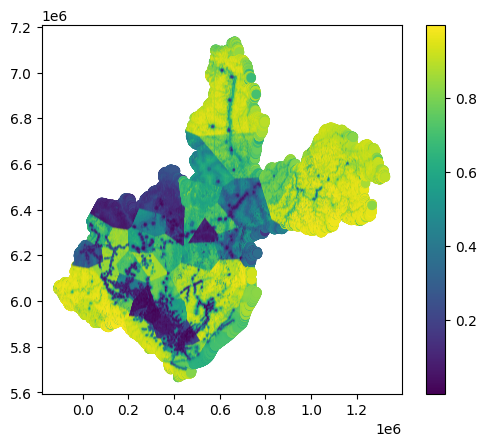

In [14]:
df_points.plot(aspect=1, column="class_0", legend=True)

In [15]:
df_points=pd.DataFrame(repalce_geometry_with_wkb(df_points))

In [16]:
df_points.drop(columns=["coords"], inplace=True)
df_points.head()

,id,dist_to_river,dist_to_road,dist_to_set,weather_station_id,elevation,aspect,slope,vegetation,WW_code,class_0,class_1,geom
0,73766,5.530808,83.192605,85.975689,29789,1872.000000,-1.0,3.955480,6.0,98.0,0.723565,0.276435,0101000000BEB901D76718FAC0D101AAEEE71C5741
1,73768,5.020281,82.725073,85.494492,29789,628.474022,-1.0,3.025684,21.0,98.0,0.908973,0.091027,0101000000BEB901D76718FAC0D101AAEEF31A5741
2,73769,4.902261,82.508367,85.270344,29789,1898.000000,-1.0,12.859591,21.0,98.0,0.970065,0.029935,0101000000BEB901D76718FAC0D101AAEEF9195741
3,73771,4.569096,82.109525,84.855385,29789,1782.000000,-1.0,10.019883,6.0,98.0,0.711624,0.288376,0101000000BEB901D76718FAC0D101AAEE05185741
4,73772,4.448839,81.927558,84.664737,29789,1642.000000,-1.0,7.298995,21.0,98.0,0.967899,0.032101,0101000000BEB901D76718FAC0D101AAEE0B175741


In [17]:
df_points.drop(
    columns=[
        "dist_to_river",
        "dist_to_road",
        "dist_to_set",
        "weather_station_id",
        "elevation",
        "aspect",
        "slope",
        "vegetation",
        "WW_code",
    ],
    inplace=True,
)

In [18]:
df_points.head()

,id,class_0,class_1,geom
0,73766,0.723565,0.276435,0101000000BEB901D76718FAC0D101AAEEE71C5741
1,73768,0.908973,0.091027,0101000000BEB901D76718FAC0D101AAEEF31A5741
2,73769,0.970065,0.029935,0101000000BEB901D76718FAC0D101AAEEF9195741
3,73771,0.711624,0.288376,0101000000BEB901D76718FAC0D101AAEE05185741
4,73772,0.967899,0.032101,0101000000BEB901D76718FAC0D101AAEE0B175741


In [20]:
df_points.drop(columns=["id"], inplace=True)

In [21]:
fileName = "risk_summer_1.csv"
path_to_json = my_data_path + "test points/" + fileName
df_points.to_csv(path_to_json)

In [22]:
# lat = []
# lon = []
for i in range(len(df_points)):
    df_points.loc[i, "geom"] = shapely.from_wkb(df_points.loc[i]["geom"])

C:\Users\pilno\AppData\Local\Temp\ipykernel_10988\507934062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_points.loc[i]["geom"] = shapely.from_wkb(df_points.loc[i]["geom"])


In [23]:
df_points.head()

,class_0,class_1,geom
0,0.723565,0.276435,0101000000BEB901D76718FAC0D101AAEEE71C5741
1,0.908973,0.091027,0101000000BEB901D76718FAC0D101AAEEF31A5741
2,0.970065,0.029935,0101000000BEB901D76718FAC0D101AAEEF9195741
3,0.711624,0.288376,0101000000BEB901D76718FAC0D101AAEE05185741
4,0.967899,0.032101,0101000000BEB901D76718FAC0D101AAEE0B175741


In [ ]:
prog_fig = px.choropleth_mapbox(df_points, df_points["geom"])

prog_fig.show()